In [2]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [4]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [15]:
POS_PATH=os.path.join('data', 'positive')
NEG_PATH=os.path.join('data', 'negative')
ANC_PATH=os.path.join('data', 'anchor')

In [13]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [14]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [17]:
import uuid

In [13]:
cap=cv2.VideoCapture(0)

while cap.isOpened():
    ret,frame=cap.read()

    frame=frame[120:120+250,200:200+250,:]

    if cv2.waitKey(1) & 0xFF==ord('a'):
        imgname=os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)


    if cv2.waitKey(1) & 0xFF==ord('p'):
        imgname=os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)


    cv2.imshow('Image Collection',frame)

    if cv2.waitKey(1) & 0xFF==ord('q'):
        break


cap.release()
cv2.destroyAllWindows()

TypeError: 'NoneType' object is not subscriptable

In [16]:
anchor=tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
negative=tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)
positive=tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)

In [17]:
dir_test=anchor.as_numpy_iterator()

In [18]:
def preprocess(file_path):
    byte_img=tf.io.read_file(file_path)
    img=tf.io.decode_jpeg(byte_img)
    img=tf.image.resize(img,(100,100))
    img=img/255.0
    return img

In [19]:
positives=tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives=tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data=positives.concatenate(negatives)

In [20]:
samples=data.as_numpy_iterator()

In [21]:
example=samples.next()

In [22]:
example

(b'data\\anchor\\e15f4264-d49a-11ee-a7c3-c8b29b1045c2.jpg',
 b'data\\positive\\f68d7d0c-d49a-11ee-a88b-c8b29b1045c2.jpg',
 1.0)

In [23]:
def preprocess_twin(input_img,validation_img,label):
    return(preprocess(input_img),preprocess(validation_img),label)

In [24]:
res=preprocess_twin(*example)

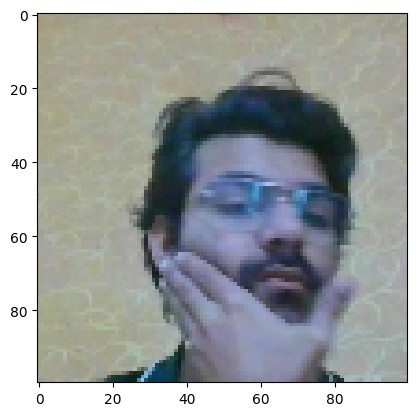

In [25]:
plt.imshow(res[1])

In [26]:
res[2]

1.0

In [27]:
data=data.map(preprocess_twin)
data=data.cache()
data=data.shuffle(buffer_size=1024)

In [28]:
train_data=data.take(round(len(data)*.7))
train_data=train_data.batch(16)
train_data=train_data.prefetch(8)

In [29]:
test_data=data.skip(round(len(data)*.7))
test_data=test_data.take(round(len(data)*.3))
test_data=test_data.batch(16)
test_data=test_data.prefetch(8)

In [30]:
def make_embedding():
    inp=Input(shape=(100,100,3), name='input_image')

    c1=Conv2D(64,(10,10),activation='relu')(inp)
    m1=MaxPooling2D(64,(2,2),padding='same')(c1)

    c2=Conv2D(128,(7,7),activation='relu')(m1)
    m2=MaxPooling2D(64,(2,2),padding='same')(c2)

    c3=Conv2D(128,(4,4),activation='relu')(m2)
    m3=MaxPooling2D(64,(2,2),padding='same')(c3)

    c4=Conv2D(256,(4,4),activation='relu')(m3)
    f1=Flatten()(c4)
    d1=Dense(4096,activation='sigmoid')(f1)

    return Model(inputs=[inp],outputs=[d1],name='embedding')

In [37]:
embedding=make_embedding()

In [38]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 128)         0 

In [6]:
class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()

    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding-validation_embedding)

In [35]:
l1=L1Dist()

In [36]:
l1

In [39]:
def make_siamese_model():
    input_image=Input(name='input_img', shape=(100,100,3))

    validation_image=Input(name='validation_img', shape=(100,100,3))

    siamese_layer=L1Dist()
    siamese_layer._name='distance'
    distances=siamese_layer(embedding(input_image),embedding(validation_image))

    classifier=Dense(1,activation='sigmoid')(distances)

    return Model(inputs=[input_image,validation_image],outputs=classifier,name='SiameseNetwork')

In [40]:
siamese_model=make_siamese_model()

In [41]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]     

In [30]:
binary_cross_loss=tf.losses.BinaryCrossentropy()

In [31]:
opt=tf.keras.optimizers.Adam(1e-4)

In [44]:
checkpoint_dir='./training_checkpoints'
checkpoint_prefix=os.path.join(checkpoint_dir,'ckpt')
checkpoint=tf.train.Checkpoint(opt=opt,siamese_model=siamese_model)

In [45]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X=batch[:2]

        y=batch[2]

        yhat=siamese_model(X,training=True)

        loss=binary_cross_loss(y,yhat)

    grad=tape.gradient(loss,siamese_model.trainable_variables)

    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
    return loss

In [48]:
def train(data,EPOCHS):
    for epoch in range(1,EPOCHS+1):
        print('\nEpoch{}/{}'.format(epoch, EPOCHS))
        progbar=tf.keras.utils.Progbar(len(data))

        for idx,batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)

        if epoch%10==0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [49]:
EPOCHS=50

In [50]:
train(train_data,EPOCHS)


Epoch1/50
27/27 [==============================] - 692s 25s/step

Epoch2/50
27/27 [==============================] - 962s 36s/step

Epoch3/50
27/27 [==============================] - 1202s 44s/step

Epoch4/50
27/27 [==============================] - 713s 26s/step

Epoch5/50
27/27 [==============================] - 727s 27s/step

Epoch6/50
27/27 [==============================] - 1388s 51s/step

Epoch7/50
27/27 [==============================] - 1386s 51s/step

Epoch8/50
27/27 [==============================] - 1395s 52s/step

Epoch9/50
27/27 [==============================] - 1425s 53s/step

Epoch10/50
27/27 [==============================] - 1385s 51s/step

Epoch11/50
27/27 [==============================] - 1381s 51s/step

Epoch12/50
27/27 [==============================] - 1385s 51s/step

Epoch13/50
27/27 [==============================] - 1384s 51s/step

Epoch14/50
27/27 [==============================] - 1379s 51s/step

Epoch15/50
27/27 [==============================] - 1384s 51

In [32]:
from tensorflow.keras.metrics import Precision, Recall

In [33]:
test_input, test_val, y_true=test_data.as_numpy_iterator().next()

In [34]:
y_hat=siamese_model.predict([test_input,test_val])

NameError: name 'siamese_model' is not defined

In [56]:
y_hat

array([[1.00731064e-04],
       [9.99998450e-01],
       [3.16854175e-06],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [2.10904361e-08],
       [1.00000000e+00],
       [9.05845265e-09],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [8.54135891e-08],
       [9.99955177e-01],
       [9.99999046e-01],
       [8.79950761e-08]], dtype=float32)

In [59]:
[1 if prediction>0.5 else 0 for prediction in y_hat]

[0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0]

In [60]:
y_true

array([0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0.],
      dtype=float32)

In [61]:
m=Recall()
m.update_state(y_true,y_hat)
m.result().numpy()

1.0

In [64]:
m=Precision()
m.update_state(y_true,y_hat)
m.result().numpy()

1.0

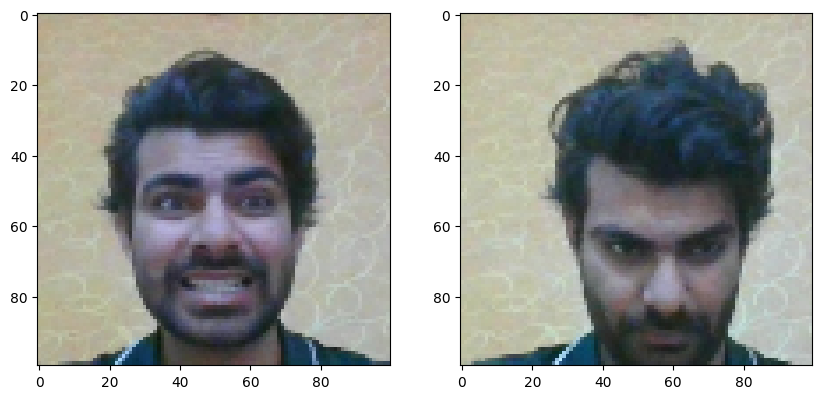

In [70]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[1])
plt.subplot(1,2,2)
plt.imshow(test_val[1])
plt.show()

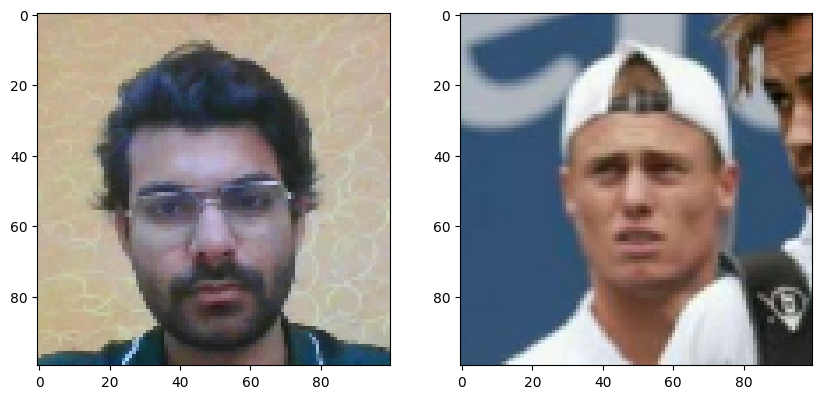

In [69]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[0])
plt.subplot(1,2,2)
plt.imshow(test_val[0])
plt.show()

In [71]:
siamese_model.save('siamesemodel.h5')

In [7]:
model=tf.keras.models.load_model('siamesemodel.h5',custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [35]:
model.predict([test_input,test_val])

array([[9.99217629e-01],
       [2.40731424e-07],
       [1.85342390e-08],
       [3.91267330e-09],
       [3.75142477e-08],
       [6.75377798e-09],
       [1.00000000e+00],
       [1.34843776e-05],
       [4.82752043e-08],
       [9.99999821e-01],
       [6.43228475e-08],
       [1.00000000e+00],
       [3.19239710e-08],
       [4.86021445e-09],
       [5.09017354e-07],
       [1.14772135e-07]], dtype=float32)

In [36]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist (L1Dist)                (None, 4096)         0           embedding[0][0]     

In [37]:
def verify(model,detection_threshold,verfication_threshold):
    results=[]
    for image in os.listdir(os.path.join('application_data','verification_images')):
        input_img=preprocess(os.path.join('application_data','input_image','input_image.jpg'))
        validation_img=preprocess(os.path.join('application_data','verification_images',image))


        result=model.predict(list(np.expand_dims([input_img,validation_img],axis=1)))
        results.append(result)

    detection=np.sum(np.array(results)>detection_threshold)
    
    verification=detection/len(os.listdir(os.path.join('application_data','verification_images')))
    verified=verification>verfication_threshold

    return results,verified


In [39]:
cap=cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame=cap.read()
    frame=frame[120:120+250,200:200+250,:]


    cv2.imshow('Verification',frame)

    if cv2.waitKey(10)& 0xFF==ord('v'):
        cv2.imwrite(os.path.join('application_data','input_image','input_image.jpg'),frame)
        results,verified=verify(model,0.9,0.7)
        print(verified)


    if cv2.waitKey(10)& 0xFF==ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

True
True
True
